In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import MSTL
from feature_engine.timeseries.forecasting import LagFeatures
from feature_engine.imputation import DropMissingData
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score,mean_absolute_percentage_error, root_mean_squared_error
import numpy as np

### Load data from data mart 

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Postgres and Snowflake") \
    .config("spark.jars.packages",
            "net.snowflake:spark-snowflake_2.12:2.11.0-spark_3.3,"
            "net.snowflake:snowflake-jdbc:3.13.22") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.executor.memoryOverhead", "2g") \
    .getOrCreate()

:: loading settings :: url = jar:file:/home/hadoop/spark-3.5.5-bin-hadoop3/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/hadoop/.ivy2/cache
The jars for the packages stored in: /home/hadoop/.ivy2/jars
net.snowflake#spark-snowflake_2.12 added as a dependency
net.snowflake#snowflake-jdbc added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-a10ab01a-745d-4fd2-ae6d-3c57935cff48;1.0
	confs: [default]
	found net.snowflake#spark-snowflake_2.12;2.11.0-spark_3.3 in central
	found net.snowflake#snowflake-ingest-sdk;0.10.8 in central
	found net.snowflake#snowflake-jdbc;3.13.22 in central
:: resolution report :: resolve 165ms :: artifacts dl 8ms
	:: modules in use:
	net.snowflake#snowflake-ingest-sdk;0.10.8 from central in [default]
	net.snowflake#snowflake-jdbc;3.13.22 from central in [default]
	net.snowflake#spark-snowflake_2.12;2.11.0-spark_3.3 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|d

In [3]:
from dotenv import load_dotenv
import os

dotenv_path = os.path.abspath("../../spark/.env")
load_dotenv(dotenv_path=dotenv_path)
#snowflake conector config
sfOptions = {
    "sfURL": os.getenv("SF_URL"),
    "sfUser": os.getenv("SF_USER"),
    "sfPassword": os.getenv("SF_PASSWORD"),
    "sfDatabase": os.getenv("SF_DATABASE"),
    "sfSchema": os.getenv("SF_SCHEMA"),
    "sfWarehouse": os.getenv("SF_WAREHOUSE"),
    "sfRole": os.getenv("SF_ROLE"),
    "insecureMode": "true"
}

In [ ]:
df_quarter = spark.read \
    .format("snowflake") \
    .options(**sfOptions) \
    .option("dbtable", "SALES_ANALYTICS.PUBLIC.QUARTERLY_REVENUE_PROFIT") \
    .load()

df_quarter.show()

25/06/04 15:14:54 WARN SnowflakeConnectorUtils$: Query pushdown is not supported because you are using Spark 3.5.5 with a connector designed to support Spark 3.3. Either use the version of Spark supported by the connector or install a version of the connector that supports your version of Spark.


+----------+--------------------+--------------------+
|   QUARTER|       TOTAL_REVENUE|        TOTAL_PROFIT|
+----------+--------------------+--------------------+
|2016-07-01|      1.5814737792E8|       2.941869464E7|
|2016-10-01|       7.290141138E7|       1.411524736E7|
|2017-01-01|       8.034313392E7|       1.459519352E7|
|2017-04-01|      1.2942986364E8|2.3175209410000004E7|
|2017-07-01|1.0281532778999999E8|       1.917177671E7|
|2017-10-01|       5.781664665E7|1.0559266370000001E7|
|2018-01-01|6.3218480849999994E7|1.1760817450000001E7|
|2018-04-01|      1.2014372412E8|2.1708209900000002E7|
|2018-07-01|       9.207864351E7|       1.677509946E7|
|2018-10-01|       5.183004897E7|          9381833.24|
|2019-01-01|       6.699231882E7|1.2112463520000001E7|
|2019-04-01|       1.261043595E8|       2.159581927E7|
|2019-07-01| 9.608090310000001E7|1.5282489560000002E7|
|2019-10-01|       5.617032939E7|   8762839.830000002|
|2020-01-01|       8.094498489E7|1.2222169360000003E7|
|2020-04-0

In [ ]:
df_quarter = df_quarter.toPandas()

In [18]:
df_quarter.set_index('QUARTER', inplace=True)
df_quarter.index = pd.to_datetime(df_quarter.index)
df_quarter.head()

,TOTAL_REVENUE,TOTAL_PROFIT
QUARTER,,
2016-07-01,1.581474e+08,29418694.64
2016-10-01,7.290141e+07,14115247.36
2017-01-01,8.034313e+07,14595193.52
2017-04-01,1.294299e+08,23175209.41
2017-07-01,1.028153e+08,19171776.71


In [ ]:
df_quarter.sort_index(inplace=True)
df_quarter.head()

,TOTAL_REVENUE,TOTAL_PROFIT
QUARTER,,
2010-07-01,1.185376e+08,22893695.56
2010-10-01,9.189888e+07,16744311.06
2011-01-01,1.010592e+08,18402520.18
2011-04-01,1.743677e+08,32184167.19
2011-07-01,1.517677e+08,27029159.61


In [21]:
df_quarter = df_quarter[df_quarter.index >= '2011-01-01']

### Check stationary series

In [38]:
train = df_quarter[df_quarter.index < '2021-01-01']
test = df_quarter[(df_quarter.index >= '2021-01-01') & (df_quarter.index < '2022-07-01')]

In [25]:
mstl = MSTL(train['TOTAL_PROFIT'].interpolate(method="linear"), periods=(2, 4))
res = mstl.fit()

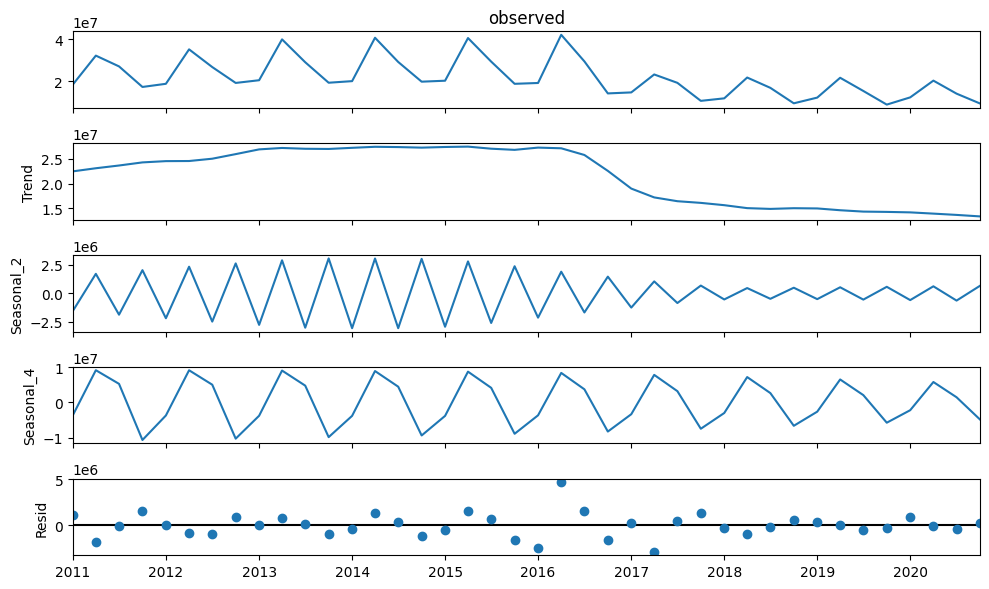

In [26]:
fig = res.plot()
fig.set_size_inches(10,6)
plt.tight_layout()
plt.show()

In [27]:
result = adfuller(res.resid)

# Trích xuất kết quả kiểm tra
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

# In kết quả
print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print('Critical Values:')
for key, value in critical_values.items():
    print(f'   {key}: {value}')

ADF Statistic: -6.0310445898389125
p-value: 1.41775774501638e-07
Critical Values:
   1%: -3.626651907578875
   5%: -2.9459512825788754
   10%: -2.6116707716049383


### Model

#### Profit

In [29]:
def linear(X_train, y_train, X_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

In [30]:
def evaluate_model(y_preds, y_true):
    return {
        'R2 score': r2_score(y_true=y_true, y_pred=y_preds),
        'MAPE': mean_absolute_percentage_error(y_true=y_true, y_pred=y_preds),
        'RMSE': root_mean_squared_error(y_true=y_true, y_pred=y_preds)
    }

In [31]:
def xgboots(X_train, y_train, X_test):
    xgb = XGBRegressor()

    param_grid = {
        'n_estimators': [30, 40, 50, 100, 200],
        'learning_rate': [0.03, 0.05, 0.1],
        'max_depth': [3, 4, 5],
        'subsample': [0.7, 0.9],
        'colsample_bytree': [0.5, 0.7]
    }

    grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print("Best parameters found: ", grid_search.best_params_)
    print("Best score found: ", grid_search.best_score_)
    best_model = grid_search.best_estimator_
    
    y_pred = best_model.predict(X_test)
    
    return y_pred


In [39]:
len(train), len(test)

(40, 6)

In [33]:
def feature_engine(columns):
    lag_transformer = LagFeatures(variables=[columns], periods=[1, 2, 4])
    imputer = DropMissingData()
    pipe = Pipeline(
        [
            ("lag", lag_transformer),
            ("imputer", imputer),
        ]
    )
    return pipe

def decomposing(data):
    mstl = MSTL(data.interpolate(method="linear"), periods=(2, 4))
    res = mstl.fit()
    return res

def prepare_features(data, component_name, lag_periods):
    pipe = feature_engine(component_name)
    data_transformed = pipe.fit_transform(data)
    
    feature_cols = [f"{component_name}_lag_{period}" for period in lag_periods]
    X = data_transformed[feature_cols]
    y = data_transformed[component_name]
    
    return X, y, pipe

def prepare_test_features(train_component, test_component, component_name, lag_periods, pipe):
    train_tail = train_component.iloc[-4:]
    extended_test = pd.concat([train_tail, test_component])


    test_transformed = pipe.transform(extended_test)
    

    feature_cols = [f"{component_name}_lag_{period}" for period in lag_periods]
    X_test = test_transformed[feature_cols]
    
    return X_test


In [34]:
def decompose_and_forecast(train, test, col_name):
    # Decompose tập train
    train_res = decomposing(train[col_name])
    train_components = {
        'trend': pd.DataFrame(train_res.trend),
        'seasonal_2': pd.DataFrame(train_res.seasonal["seasonal_2"]),
        'seasonal_4': pd.DataFrame(train_res.seasonal["seasonal_4"]),
        'resid': pd.DataFrame(train_res.resid)
    }

    # Thêm 12 tháng cuối của train vào test để decompose
    train_tail = train.iloc[-4:]
    extended_test = pd.concat([train_tail, test])

    # Decompose tập test mở rộng
    extended_test_res = decomposing(extended_test[col_name])


    test_components = {
        'trend': pd.DataFrame(extended_test_res.trend).iloc[4:],
        'seasonal_2': pd.DataFrame(extended_test_res.seasonal["seasonal_2"]).iloc[4:],
        'seasonal_4': pd.DataFrame(extended_test_res.seasonal["seasonal_4"]).iloc[4:],
        'resid': pd.DataFrame(extended_test_res.resid).iloc[4:]
    }

    component_configs = {
        'trend': {'lag_periods': [1, 2, 4], 'model': 'linear'},
        'seasonal_2': {'lag_periods': [1, 2, 4], 'model': 'xgboost'},
        'seasonal_4': {'lag_periods': [2, 4], 'model': 'xgboost'},
        'resid': {'lag_periods': [1, 2, 4], 'model': 'linear'}
    }

    # Dự báo cho mỗi thành phần
    final_predictions = np.zeros(len(test))

    for component_name, config in component_configs.items():
        # Chuẩn bị dữ liệu train
        train_data = train_components[component_name]
        X_train, y_train, pipe = prepare_features(train_data, component_name, config['lag_periods'])
        
        # Chuẩn bị dữ liệu test
        test_data = test_components[component_name]
        X_test = prepare_test_features(train_data, test_data, component_name, config['lag_periods'], pipe)
        print(f"Component: {component_name}, X_test.shape: {X_test.shape}")
        
        # Huấn luyện và dự báo
        if config['model'] == 'linear':
            component_predictions = linear(X_train, y_train, X_test)
        else:
            component_predictions = xgboots(X_train, y_train, X_test)
        
        # Thêm dự báo vào kết quả cuối cùng
        final_predictions += component_predictions

    return final_predictions


In [40]:
predictions_profit = decompose_and_forecast(train, test, 'TOTAL_PROFIT')

Component: trend, X_test.shape: (6, 3)
Component: seasonal_2, X_test.shape: (6, 3)
Fitting 3 folds for each of 180 candidates, totalling 540 fits
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=30, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=30, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=30, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=30, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=40, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=40, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=40, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03

In [41]:
evaluate_model(predictions_profit, test['TOTAL_PROFIT'])

{'R2 score': 0.8826683428239959,
 'MAPE': 0.08306834404216458,
 'RMSE': 1490014.9264334883}

#### Revenue

In [43]:
predictions_revenue = decompose_and_forecast(train, test, 'TOTAL_REVENUE')

Component: trend, X_test.shape: (6, 3)
Component: seasonal_2, X_test.shape: (6, 3)
Fitting 3 folds for each of 180 candidates, totalling 540 fits
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=30, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=30, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=40, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=30, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=30, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=30, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=40, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03

In [45]:
evaluate_model(predictions_revenue, test['TOTAL_REVENUE'])

{'R2 score': 0.7879846822238945,
 'MAPE': 0.12430303523343221,
 'RMSE': 13449149.959815556}

In [46]:
pipe = feature_engine("TOTAL_REVENUE")
train_ = pipe.fit_transform(train)
train_.head(5)

,TOTAL_REVENUE,TOTAL_PROFIT,TOTAL_REVENUE_lag_1,TOTAL_REVENUE_lag_2,TOTAL_REVENUE_lag_4
QUARTER,,,,,
2012-01-01,1.051871e+08,18711317.59,9.268823e+07,1.517677e+08,1.010592e+08
2012-04-01,1.985546e+08,35177570.92,1.051871e+08,9.268823e+07,1.743677e+08
2012-07-01,1.467589e+08,26711724.74,1.985546e+08,1.051871e+08,1.517677e+08
2012-10-01,1.003007e+08,19125959.40,1.467589e+08,1.985546e+08,9.268823e+07
2013-01-01,1.081490e+08,20420521.39,1.003007e+08,1.467589e+08,1.051871e+08


In [47]:
result = []
train_copy = train.copy()  # Sao chép train để tránh thay đổi dữ liệu gốc

for i in range(len(test)):
    # Sử dụng toàn bộ dữ liệu train (không dùng test) để huấn luyện
    data = train_copy.copy()
    
    # Phân rã chuỗi thời gian
    res = decomposing(data["TOTAL_REVENUE"])
    trend = pd.DataFrame(res.trend)
    seasonal_2 = pd.DataFrame(res.seasonal["seasonal_2"])
    seasonal_4 = pd.DataFrame(res.seasonal["seasonal_4"])
    resid = pd.DataFrame(res.resid)

    # Huấn luyện trend
    pipe = feature_engine("trend")
    trend = pipe.fit_transform(trend)
    
    if len(trend) >= 4:  # Đảm bảo đủ dữ liệu để lấy lag
        X_train = trend[["trend_lag_2", "trend_lag_4"]]
        y_train = trend["trend"]
        X_test = pd.DataFrame([[y_train.iloc[-2], y_train.iloc[-4]]], columns=["trend_lag_2", "trend_lag_4"])
        trend_pred = linear(X_train, y_train, X_test)
    else:
        trend_pred = 0  # Nếu không đủ dữ liệu, giả sử không có xu hướng mới

    # Huấn luyện seasonal_2
    pipe = feature_engine("seasonal_2")
    seasonal_2 = pipe.fit_transform(seasonal_2)
    
    if len(seasonal_2) >= 4:
        X_train = seasonal_2[["seasonal_2_lag_2", "seasonal_2_lag_4"]]
        y_train = seasonal_2["seasonal_2"]
        X_test = pd.DataFrame([[y_train.iloc[-2], y_train.iloc[-4]]], columns=["seasonal_2_lag_2", "seasonal_2_lag_4"])
        seasonal_2_pred = xgboots(X_train, y_train, X_test)
    else:
        seasonal_2_pred = 0

    # Huấn luyện seasonal_4
    pipe = feature_engine("seasonal_4")
    seasonal_4 = pipe.fit_transform(seasonal_4)

    if len(seasonal_4) >= 4:
        X_train = seasonal_4[["seasonal_4_lag_4"]]
        y_train = seasonal_4["seasonal_4"]
        X_test = pd.DataFrame([[y_train.iloc[-4]]], columns=["seasonal_4_lag_4"])
        seasonal_4_pred = xgboots(X_train, y_train, X_test)
    else:
        seasonal_4_pred = 0

    # Huấn luyện resid
    pipe = feature_engine("resid")
    resid = pipe.fit_transform(resid)

    if len(resid) >= 4:
        X_train = resid[["resid_lag_1", "resid_lag_2", "resid_lag_4"]]
        y_train = resid["resid"]
        X_test = pd.DataFrame([[y_train.iloc[-1], y_train.iloc[-2], y_train.iloc[-4]]],
                              columns=["resid_lag_1", "resid_lag_2", "resid_lag_4"])
        resid_pred = linear(X_train, y_train, X_test)
    else:
        resid_pred = 0

    # Tổng hợp dự báo
    y_pred = trend_pred + seasonal_2_pred + seasonal_4_pred + resid_pred
    print(y_pred)
    result.append(y_pred)

    # Cập nhật tập train với dự báo mới để tiếp tục dự báo các bước sau
    train_copy = pd.concat([train_copy, pd.DataFrame([{"TOTAL_REVENUE": y_pred}])], ignore_index=True)


Fitting 3 folds for each of 180 candidates, totalling 540 fits
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=30, subsample=0.7; total time=   0.0s[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=30, subsample=0.7; total time=   0.0s

[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=30, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=30, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=40, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=40, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=30, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=40, subsample=0.9; total time=   0.0s
[CV] END colsampl

/tmp/ipykernel_5644/4254180492.py:13: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  mstl = MSTL(data.interpolate(method="linear"), periods=(2, 4))


[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=4, n_estimators=40, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=4, n_estimators=40, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=4, n_estimators=30, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=4, n_estimators=40, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=4, n_estimators=50, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=4, n_estimators=40, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=200, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=4, n_estimators=40, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=4, n_estimators=50

/tmp/ipykernel_5644/4254180492.py:13: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  mstl = MSTL(data.interpolate(method="linear"), periods=(2, 4))


[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=200, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=4, n_estimators=30, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=200, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=4, n_estimators=30, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=4, n_estimators=40, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=4, n_estimators=50, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=4, n_estimators

/tmp/ipykernel_5644/4254180492.py:13: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  mstl = MSTL(data.interpolate(method="linear"), periods=(2, 4))


[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=40, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=40, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=30, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=50, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=40, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=50,

/tmp/ipykernel_5644/4254180492.py:13: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  mstl = MSTL(data.interpolate(method="linear"), periods=(2, 4))


[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=50, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=50, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=4, n_estimators=30, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=4, n_estimator

/tmp/ipykernel_5644/4254180492.py:13: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  mstl = MSTL(data.interpolate(method="linear"), periods=(2, 4))


[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=50, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=50, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=50, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=4, n_estimators=30, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators

In [48]:
final_pred = pd.Series(np.array(result).flatten(), index=test.index)
test['Predicted_Revenue'] = final_pred

/tmp/ipykernel_5644/4079694695.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predicted_Revenue'] = final_pred


In [49]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error, root_mean_squared_error
def evaluate_model(y_preds, y_true):
    return {
        'R2 score': r2_score(y_true=y_true, y_pred=y_preds),
        'MAPE': mean_absolute_percentage_error(y_true=y_true, y_pred=y_preds),
        'RMSE': root_mean_squared_error(y_true=y_true, y_pred=y_preds)
    }

In [51]:
evaluate_model(test['Predicted_Revenue'], test['TOTAL_REVENUE'])

{'R2 score': 0.35181835217966007,
 'MAPE': 0.19090176060562417,
 'RMSE': 23515790.46221863}